接续特征构造与嵌入部分，更改环境为ai4s(python=3.10)

# 降维与聚类

### 读取数据

In [17]:
import numpy as np
X_loaded = np.load('molecular_fingerprints.npy')
print("从.npy文件加载的数组形状:", X_loaded.shape)
X = X_loaded
import umap

从.npy文件加载的数组形状: (200, 1061)


### 依赖

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.manifold import TSNE
import umap
print(f"原始特征矩阵形状: {X.shape}")

原始特征矩阵形状: (200, 1061)


d:\Install\miniconda\envs\a4s\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Install\miniconda\envs\a4s\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


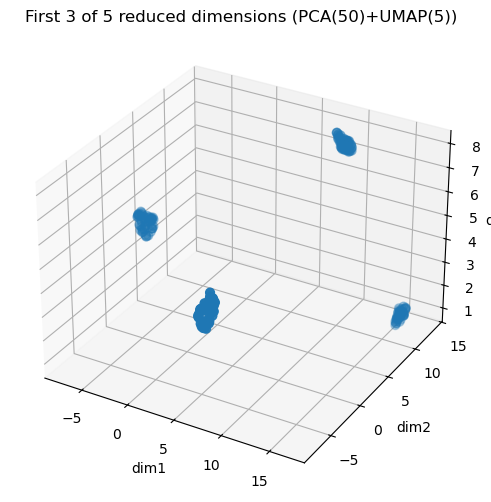

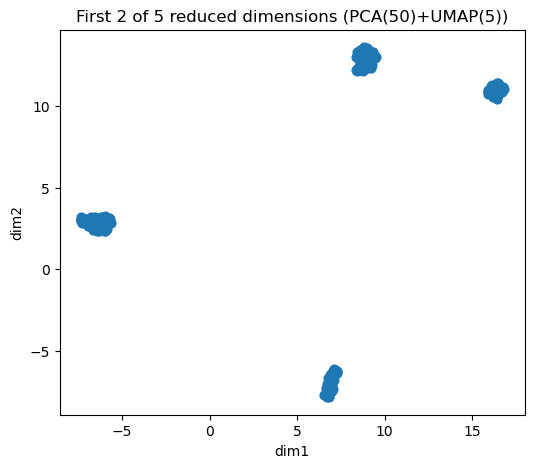

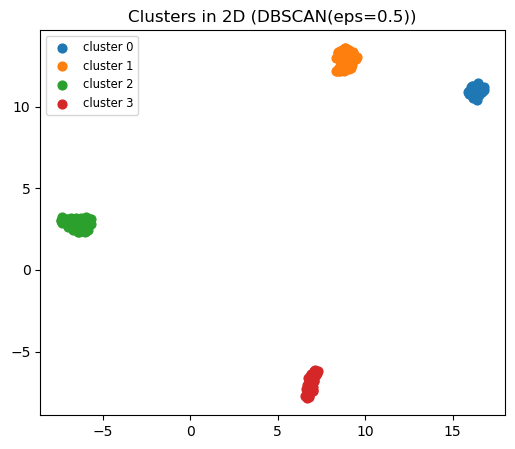

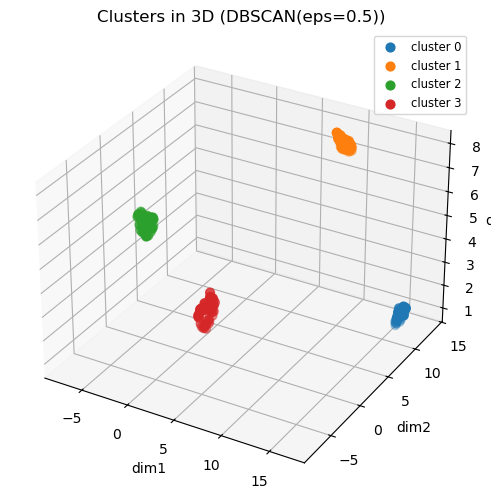

In [ ]:
# Full pipeline: Standardize -> PCA(50) -> UMAP(5) (if available) -> save reduced5
# -> plot first 3 and first 2 dims -> clustering (HDBSCAN/DBSCAN/KMeans fallback) ->
# -> plot clustered 2D and 3D -> save outputs.

import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from mpl_toolkits.mplot3d import Axes3D

# Try optional libs
use_umap = True
use_hdbscan = True
try:
    import umap
except Exception:
    use_umap = False
try:
    import hdbscan
except Exception:
    use_hdbscan = False


rng = np.random.RandomState(42)
n_samples = 200
original_dim = 1061
n_clusters_true = 4
latent_dim = 5
centers = rng.normal(scale=5.0, size=(n_clusters_true, latent_dim))
labels_true = rng.choice(n_clusters_true, size=n_samples)
Z = centers[labels_true] + 0.5 * rng.normal(size=(n_samples, latent_dim))
A = rng.normal(size=(latent_dim, original_dim))
X = Z.dot(A) + 0.1 * rng.normal(size=(n_samples, original_dim))
# -----------------------

# Standardize
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# PCA->(UMAP) pipeline
pca_stage = PCA(n_components=50, random_state=0)
X_pca50 = pca_stage.fit_transform(Xs)

if use_umap:
    reducer = umap.UMAP(n_components=5, random_state=42)
    X5 = reducer.fit_transform(X_pca50)
    method_used = "PCA(50)+UMAP(5)"
else:
    pca5 = PCA(n_components=5, random_state=0)
    X5 = pca5.fit_transform(X_pca50)
    method_used = "PCA(50)+PCA(5)"

os.makedirs("/mnt/data", exist_ok=True)
np.save("/mnt/data/reduced_5d.npy", X5)

# Plot first 3 and first 2 dims
fig1 = plt.figure(figsize=(7,6))
ax = fig1.add_subplot(111, projection='3d')
ax.scatter(X5[:,0], X5[:,1], X5[:,2], s=40)
ax.set_xlabel("dim1"); ax.set_ylabel("dim2"); ax.set_zlabel("dim3")
ax.set_title("First 3 of 5 reduced dimensions ({})".format(method_used))
fig1.savefig("/mnt/data/reduced_3d.png", dpi=150)

fig2 = plt.figure(figsize=(6,5))
plt.scatter(X5[:,0], X5[:,1], s=40)
plt.xlabel("dim1"); plt.ylabel("dim2")
plt.title("First 2 of 5 reduced dimensions ({})".format(method_used))
fig2.savefig("/mnt/data/reduced_2d.png", dpi=150)

# Clustering: HDBSCAN -> DBSCAN grid -> KMeans fallback
cluster_labels = None
cluster_method = None

if use_hdbscan:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=8)
    cluster_labels = clusterer.fit_predict(X5)
    cluster_method = "HDBSCAN"
else:
    # try DBSCAN with a small grid of eps
    selected = None
    for eps in [0.5, 1.0, 1.5, 2.0]:
        db = DBSCAN(eps=eps, min_samples=5)
        labels = db.fit_predict(X5)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters > 1:
            selected = (labels, eps)
            break
    if selected is not None:
        cluster_labels = selected[0]
        cluster_method = f"DBSCAN(eps={selected[1]})"
    else:
        # fallback to KMeans; choose k based on domain knowledge or silhouette externally
        k = 4
        km = KMeans(n_clusters=k, random_state=0, n_init=10).fit(X5)
        cluster_labels = km.labels_
        cluster_method = f"KMeans(k={k})"

np.save("/mnt/data/cluster_labels.npy", cluster_labels)

# Plot clusters 2D and 3D
unique_labels = np.unique(cluster_labels)
fig3 = plt.figure(figsize=(6,5))
for lab in unique_labels:
    mask = (cluster_labels == lab)
    labname = "noise" if lab == -1 else f"cluster {lab}"
    plt.scatter(X5[mask,0], X5[mask,1], label=labname, s=40)
plt.legend(loc='best', fontsize='small')
plt.title("Clusters in 2D ({})".format(cluster_method))
plt.savefig("/mnt/data/clustered_2d.png", dpi=150)

fig4 = plt.figure(figsize=(8,6))
ax = fig4.add_subplot(111, projection='3d')
for lab in unique_labels:
    mask = (cluster_labels == lab)
    
    ax.scatter(X5[mask,0], X5[mask,1], X5[mask,2], label=("noise" if lab==-1 else f"cluster {lab}"), s=40)
ax.set_xlabel("dim1"); ax.set_ylabel("dim2"); ax.set_zlabel("dim3")
ax.set_title("Clusters in 3D ({})".format(cluster_method))
ax.legend(loc='best', fontsize='small')
fig4.savefig("/mnt/data/clustered_3d.png", dpi=150)

plt.show()


=== 降维后五个维度的详细信息 ===
降维方法: PCA(50)+UMAP(5)
降维后数据形状: (200, 5)

各维度的统计信息:
  维度 1:
    均值: 6.1722
    标准差: 8.2278
    最小值: -7.3611
    最大值: 16.8049
    中位数: 7.8312
  维度 2:
    均值: 5.0799
    标准差: 7.7337
    最小值: -7.8280
    最大值: 13.6008
    中位数: 6.8346
  维度 3:
    均值: 4.5906
    标准差: 2.1529
    最小值: 0.9244
    最大值: 8.0119
    中位数: 4.6972
  维度 4:
    均值: 2.7326
    标准差: 2.8613
    最小值: -2.3240
    最大值: 6.4628
    中位数: 3.6654
  维度 5:
    均值: 4.0009
    标准差: 4.6710
    最小值: -3.0811
    最大值: 11.0272
    中位数: 4.0491

=== 各维度在聚类中的重要性 ===
各维度对聚类结果的F统计量(越大越重要):
  维度 1: F-score = 34994.5391, p-value = 0.0000
  维度 2: F-score = 26059.9375, p-value = 0.0000
  维度 3: F-score = 3772.4814, p-value = 0.0000
  维度 4: F-score = 4571.6411, p-value = 0.0000
  维度 5: F-score = 21080.4434, p-value = 0.0000


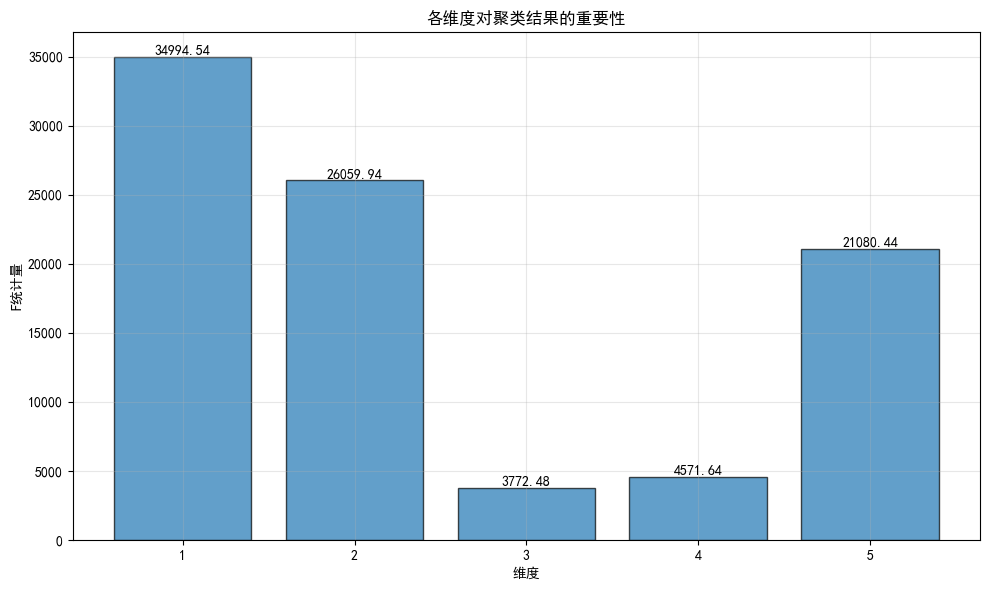

In [25]:
plt.rcParams['font.family'] = 'SimHei'


# 查看最后五个维度的信息
print("=== 降维后五个维度的详细信息 ===")
print(f"降维方法: {method_used}")
print(f"降维后数据形状: {X5.shape}")

# 显示每个维度的基本统计信息
print("\n各维度的统计信息:")
for i in range(X5.shape[1]):
    dim_data = X5[:, i]
    print(f"  维度 {i+1}:")
    print(f"    均值: {np.mean(dim_data):.4f}")
    print(f"    标准差: {np.std(dim_data):.4f}")
    print(f"    最小值: {np.min(dim_data):.4f}")
    print(f"    最大值: {np.max(dim_data):.4f}")
    print(f"    中位数: {np.median(dim_data):.4f}")


# 如果想要了解这些维度在聚类中的重要性
print("\n=== 各维度在聚类中的重要性 ===")
from sklearn.feature_selection import f_classif

# 使用F统计量评估各维度对聚类结果的贡献

if cluster_labels is not None and len(np.unique(cluster_labels)) > 1:
    # 移除噪声点(-1标签)进行分析
    mask = cluster_labels != -1
    if np.sum(mask) > 0:
        X5_clean = X5[mask]
        labels_clean = cluster_labels[mask]
        
        f_scores, p_values = f_classif(X5_clean, labels_clean)
        
        print("各维度对聚类结果的F统计量(越大越重要):")
        for i, (f_score, p_value) in enumerate(zip(f_scores, p_values)):
            print(f"  维度 {i+1}: F-score = {f_score:.4f}, p-value = {p_value:.4f}")
        
        # 可视化特征重要性
        plt.figure(figsize=(10, 6))
        bars = plt.bar(range(1, 6), f_scores, alpha=0.7, edgecolor='black')
        plt.xlabel('维度')
        plt.ylabel('F统计量')
        plt.title('各维度对聚类结果的重要性')
        plt.xticks(range(1, 6))
        
        # 在柱子上显示数值
        for i, (bar, f_score) in enumerate(zip(bars, f_scores)):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f'{f_score:.2f}', ha='center', va='bottom')
        
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('/mnt/data/dimension_importance.png', dpi=150)
        plt.show()


plt.show()

In [21]:
# 显示每个聚类的详细信息
print("=== 聚类详细信息 ===")
print(f"使用的聚类方法: {cluster_method}")

# 统计每个簇的点数
unique_labels, counts = np.unique(cluster_labels, return_counts=True)

print(f"\n聚类总数: {len(unique_labels)}")
print("各簇的点数分布:")

# 按簇显示详细信息
for label, count in zip(unique_labels, counts):
    if label == -1:
        print(f"  噪声点: {count} 个点")
    else:
        print(f"  簇 {label}: {count} 个点")

# 显示每个簇包含的具体点的索引
print("\n各簇包含的点的索引:")
for label in unique_labels:
    # 找到属于该簇的所有点的索引
    indices = np.where(cluster_labels == label)[0]
    if label == -1:
        print(f"  噪声点 (索引): {indices.tolist()}")
    else:
        print(f"  簇 {label} (索引): {indices.tolist()}")

# 计算一些统计信息
n_noise = counts[unique_labels == -1][0] if -1 in unique_labels else 0
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
n_clustered_points = len(cluster_labels) - n_noise

print(f"\n=== 聚类统计摘要 ===")
print(f"总点数: {len(cluster_labels)}")
print(f"聚类点数: {n_clustered_points}")
print(f"噪声点数: {n_noise}")
print(f"有效簇数: {n_clusters}")
if n_clusters > 0:
    print(f"平均每簇点数: {n_clustered_points/n_clusters:.1f}")

=== 聚类详细信息 ===
使用的聚类方法: DBSCAN(eps=0.5)

聚类总数: 4
各簇的点数分布:
  簇 0: 47 个点
  簇 1: 53 个点
  簇 2: 52 个点
  簇 3: 48 个点

各簇包含的点的索引:
  簇 0 (索引): [0, 1, 3, 17, 21, 22, 23, 25, 27, 38, 41, 44, 45, 46, 47, 48, 50, 53, 54, 56, 57, 58, 60, 65, 69, 74, 78, 107, 109, 116, 121, 127, 134, 138, 141, 147, 148, 160, 174, 176, 177, 179, 182, 188, 189, 192, 197]
  簇 1 (索引): [2, 4, 6, 10, 12, 13, 16, 30, 32, 36, 37, 52, 61, 63, 66, 75, 86, 90, 97, 98, 99, 102, 103, 105, 108, 112, 119, 120, 124, 128, 129, 131, 133, 135, 139, 140, 142, 143, 145, 146, 151, 152, 154, 162, 163, 165, 166, 171, 172, 173, 190, 193, 196]
  簇 2 (索引): [5, 7, 8, 18, 20, 28, 29, 31, 33, 35, 40, 42, 43, 49, 55, 59, 62, 64, 67, 70, 72, 77, 80, 81, 82, 92, 94, 95, 96, 101, 111, 114, 115, 118, 122, 125, 126, 149, 153, 156, 158, 159, 168, 170, 175, 183, 184, 185, 186, 187, 191, 194]
  簇 3 (索引): [9, 11, 14, 15, 19, 24, 26, 34, 39, 51, 68, 71, 73, 76, 79, 83, 84, 85, 87, 88, 89, 91, 93, 100, 104, 106, 110, 113, 117, 123, 130, 132, 136, 137, 144, 1